In [6]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
from importlib import reload
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy
import torch

import sys
sys.path.append('/home/plcristille/dev/utils')
import plot
from plot import load_dataset_SYNTHETIC_NOISY, load_unmixed_dataset_SYNTHETIC, plot_sampled_images, plot_spec, norm_hypercube
from plot import return_mixture, noise_data_for_snr, add_poisson_noise, unmix
sys.path.append('/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case')
import instrument_models
from instrument_models import Spectrometer_Model, Imager_Model, Spectrometer_Model_fast, Imager_Model_fast, Mirim_Model_For_Fusion, Spectro_Model_3


sys.path.append('/home/plcristille/dev/JWST/Instrument_func/')
import functions_for_fusion_end_to_end
from functions_for_fusion_end_to_end import Mirim_Model_Cube, Spectro_Model_Cube, Mirim_Model_Cube_for_Tensors
from functions_for_fusion_end_to_end import Spectro_Model_Cube_for_Tensors, maps_to_cube, np_to_var, min_not_zero, rescale_0_1, var_to_np


In [7]:
wavelength_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")
NIRCam_pce = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRCam/NIRCam_PCE.npy")
NIRCam_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRCam_PSFs.npy")
NIRSpec_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRSpec_PSFs.npy")
NIRSpec_PSF = NIRSpec_PSF / np.sqrt((NIRSpec_PSF**2).sum(axis=(1,2), keepdims=True))

L_pce_NIRSpec = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRSpec/NIRSpec_PCE.npy")
spec_database = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/spectra_dataset.npy")

# mixture_specs = spec_database[np.random.choice(range(spec_database.shape[0]), 5, replace=False)]
# np.save("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/test_mixture_specs.npy", mixture_specs)
mixture_specs = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/test_mixture_specs.npy")

size = (40,40)
di, dj = 2, 2
margin = 8


x_old = np.linspace(0, 1, mixture_specs.shape[1])
x_new = np.linspace(0, 1, L_pce_NIRSpec.shape[0])

interp_func = interp1d(x_old, mixture_specs, kind='linear', axis=1, fill_value="extrapolate")
mixture_specs = interp_func(x_new)

# mixture_specs = norm_hypercube(mixture_specs, min_value=0,max_value=600)

In [8]:
spat_ss = 2

fname_true_maps = "/home/plcristille/dev/JWST/Instrument_func/Abundance_maps_NEW.fits"
fits_cube = fits.open(fname_true_maps)
true_maps = np.asarray(fits_cube[0].data, dtype=np.float32)[:, ::spat_ss, :: spat_ss]
true_maps.shape

# MODIFYING ABUNDANCE MAP 1

true_maps[0][true_maps[0] > 0.8] = 0.8

# MODIFYING ABUNDANCE MAP 4

n_map = 3

map4 = true_maps[n_map]
# plt.imshow(map4)

d = 20
i1, j1 = 104, 202
# star1 = map4[i1 - d : i1 + d, j1 - d : j1 + d]
i2, j2 = 121, 318
# star2 = map4[i2 - d : i2 + d, j2 - d : j2 + d]
i3, j3 = 113, 345
# star3 = map4[i3 - d : i3 + d, j3 - d : j3 + d]
# star3.shape

mask = np.zeros((2 * d, 2 * d))
mask.shape

# plt.imshow(star3)

map4[i1 - d : i1 + d, j1 - d : j1 + d] = mask
map4[i2 - d : i2 + d, j2 - d : j2 + d] = mask
map4[i3 - d : i3 + d, j3 - d : j3 + d] = mask

# plt.imshow(map4)


# changing values of map 4
map4[map4 <= 0.35] = 0
min_not_zero_map_4 = min_not_zero(map4)
map4[map4 == 0] = min_not_zero_map_4
map4_rescaled = rescale_0_1(map4)

map4_rescaled_blurred = gaussian_filter(map4_rescaled, 1.4)

map4_rerescaled = rescale_0_1(map4_rescaled_blurred)

true_maps[n_map] = map4_rerescaled

shape_target = true_maps.shape[1:]

# IF SUBSAMPLING
true_maps = true_maps[:, ::2, ::2]
rect_ld = (152,40,size[0],size[1])

# ELSE
# rect_ld = (310,100,size[0],size[1])

true_maps = true_maps[:, rect_ld[1]:rect_ld[1]+size[1], rect_ld[0]:rect_ld[0]+size[0]]
# plot_sampled_images(true_maps, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))

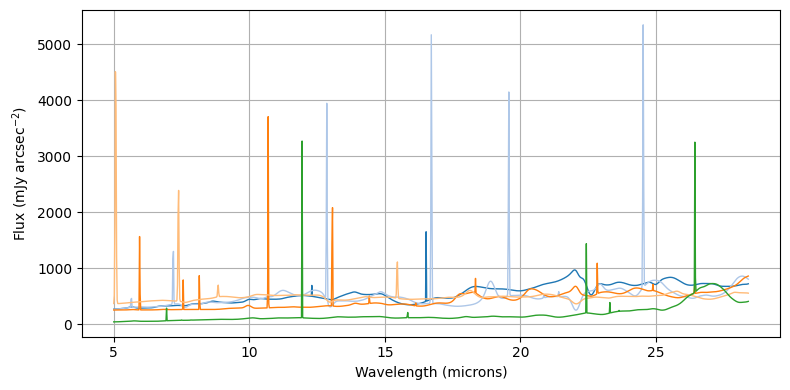

In [9]:
def constrain_variate_abundance(abundances):
    abundances = norm_hypercube(abundances)
    weights = np.random.uniform(.5, 2.0, abundances.shape[0])
    logits = np.log(abundances + 1e-8) + np.log(weights[:, None, None])  # Log reweighting
    abundances_new = np.exp(logits)
    return norm_hypercube(abundances_new)

true_maps = constrain_variate_abundance(true_maps)

spectra_broadcasted = mixture_specs[:, None, None, :]
abundances_expanded = true_maps[..., None]
GT = np.sum(abundances_expanded * spectra_broadcasted, axis=0).transpose(2,0,1)



np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_true_maps.npy",true_maps)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_L_specs.npy",mixture_specs)

# GT = return_mixture(mixture_specs, true_maps.T)
# maps, L_specs, scaler = unmix(GT, scaler=None, alpha_W=1e-3, alpha_H='same', l1_ratio=0.0)

maps, L_specs = true_maps, mixture_specs

# plot_sampled_images(maps, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_spec(L_specs)

In [10]:
# lamb_cube = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")

# rect_ld = (152+4,40+4,32,32)
# rect_spec = (3.5,9.5,2,2)
# disp_band = 500

# _=plot_sampled_images([GT[disp_band],GT[disp_band,rect_ld[1]:rect_ld[1]+32, rect_ld[0]:rect_ld[0]+32]],
#                     filters=[f"GT - {lamb_cube[disp_band]:.2f}μ", r"GT $a_1$ - {:.2f}μ".format(lamb_cube[disp_band])],
#                     rect_locDim=(rect_ld,rect_spec), ax_rect={1 : (1,), 2 : (2,)},
#                     rect_name=[r"$a_1$",r"$a_2$"],
#                     savepath="/home/plcristille/dev/Spline_fusion/Media/scene.pdf")

# plot_spec(GT[:,rect_ld[1]:rect_ld[1]+32, rect_ld[0]:rect_ld[0]+32][:,int(rect_spec[1]+.5):int(rect_spec[1]+.5)+int(rect_spec[3]), int(rect_spec[0]+.5):int(rect_spec[0]+.5)+int(rect_spec[2])].reshape(1106,4).T,
#           filters=["pixel 1", "pixel 2", "pixel 3", "pixel 4"],
#           wavelength = lamb_cube,
#           savepath="/home/plcristille/dev/Spline_fusion/Media/spec_simil.pdf")

In [35]:
reload(instrument_models)

################################################
########## FOR FLAT CALIBRATION IMAGE ##########
################################################

# L_specs_1 = np.ones_like(L_specs)
# maps_1 = np.full((L_specs_1.shape[0], maps.shape[1], maps.shape[2]), 1.0 / L_specs_1.shape[0])

# spectro_model = Spectrometer_Model(
#     NIRSpec_PSF, L_pce_NIRSpec, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
# )
# spectro_flat = spectro_model.forward(maps_1, L_specs_1, decimate=True)
# spectro_flat = spectro_model.forward(maps_1, L_specs_1, decimate=True)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]
# np.save(f"/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/FLAT_spectro_{spectro_flat.shape[1]}", spectro_flat)

imager_model = instrument_models.Imager_Model(
    NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
)

imager_model_fast = instrument_models.Imager_Model_fast(
    NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
)

spectro_model = instrument_models.Spectrometer_Model(
    NIRSpec_PSF, L_pce_NIRSpec, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
)

spectro_model_fast = instrument_models.Spectrometer_Model_fast(
    NIRSpec_PSF, L_pce_NIRSpec, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
)


# imager_model = instrument_models.Imager_Model(
#     NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
# )

# spectro_model = instrument_models.Spectrometer_Model(
#     NIRSpec_PSF, L_pce_NIRSpec, wavelength_NIRSpec, size, mixture_specs.shape[0], di, dj
# )

In [36]:

# MS_fast = imager_model_fast.forward(true_maps, mixture_specs)[:, margin//2:-margin//2, margin//2:-margin//2]
# MS = imager_model.forward(true_maps, mixture_specs)[:, margin//2:-margin//2, margin//2:-margin//2]
HS = spectro_model.forward(true_maps, mixture_specs, decimate=True)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]
HS_fast = spectro_model_fast.forward(true_maps, mixture_specs, decimate=True)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]
# [:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]


# spectro_model_flat = instrument_models.Spectro_Model_3(
#     NIRSpec_PSF, L_pce_NIRSpec, di, dj, wavelength_NIRSpec, L_specs_1, size, old_model=False
# )
# spectro_flat = spectro_model_flat.forward(maps_1)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]


# imager_model = instrument_models.Mirim_Model_For_Fusion(
#     NIRCam_PSF, NIRCam_pce, wavelength_NIRSpec, L_specs, size, di, dj,
# )
# spectro_model = instrument_models.Spectro_Model_3(
#     NIRSpec_PSF, L_pce_NIRSpec, di, dj, wavelength_NIRSpec, L_specs, size, old_model=False
# )

# MS = imager_model.forward(maps)[:, margin//2:-margin//2, margin//2:-margin//2]
# HS = spectro_model.forward(maps)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]

# GT = GT[:, margin//2:-margin//2, margin//2:-margin//2]


# print(f"GT : {GT.shape}, MS : {MS.shape}, HS : {HS.shape}")
# np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/GT_NIR_{GT.shape[0]}_{GT.shape[1]}.npy", GT)
# np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/NIRCam_{GT.shape[0]}_{GT.shape[1]}.npy", MS)
# np.save(f"/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/NIRSpec_{GT.shape[0]}_{GT.shape[1]}.npy", HS)

0.147373
0.148758


In [31]:
HS_fast.shape

(1106, 16, 16)

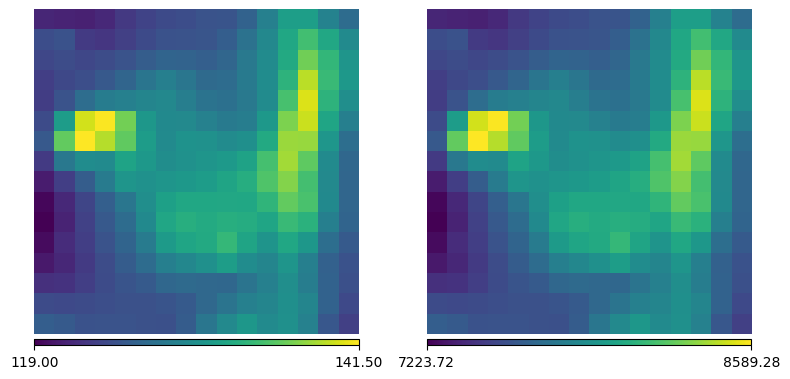

In [34]:
plot_sampled_images([HS_fast[800], HS[800]])

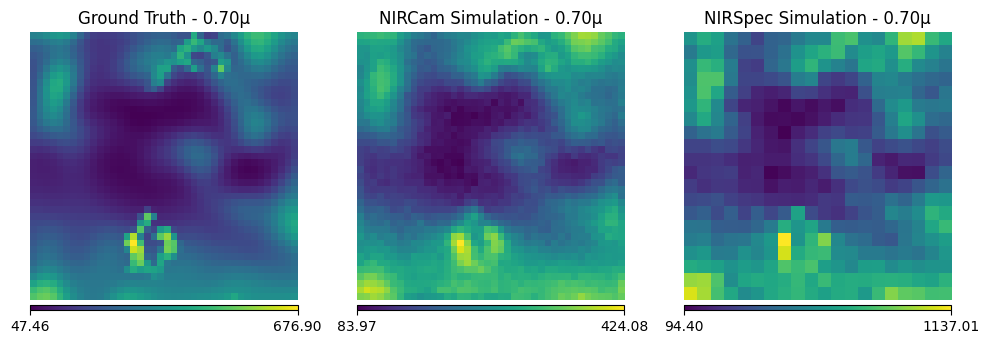

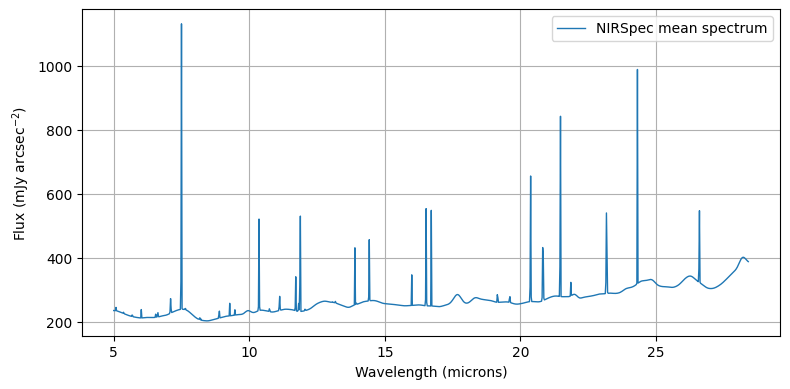

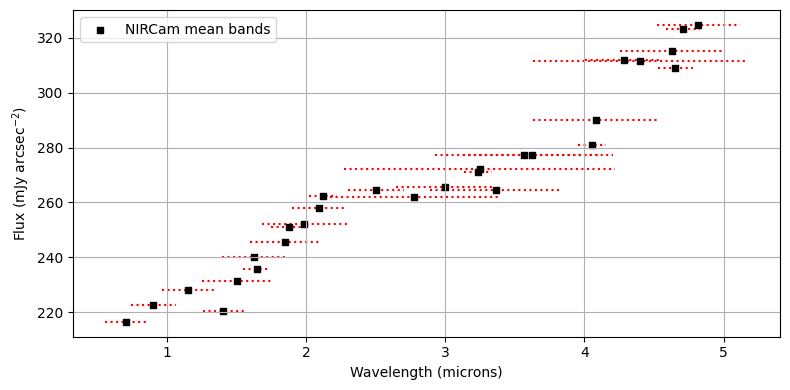

In [47]:
NOISE = True

if NOISE:
    snr_MS = 35
    snr_HS = 35
    snr_poisson = 150

    ms_poisson = add_poisson_noise(MS, [snr_poisson])
    hs_poisson = add_poisson_noise(HS, [snr_poisson])

    ms_final = noise_data_for_snr(ms_poisson, [snr_MS])[0][0]
    hs_final = noise_data_for_snr(hs_poisson, [snr_HS])[0][0]
else:
    snr_MS = "inf"
    snr_HS = "inf"
    ms_final = MS
    hs_final = HS

b_MS, b_HS = 0, 35
plot_sampled_images([GT[b_HS], ms_final[b_MS], hs_final[b_HS]], cbar=True, cbar_position='bottom', size=(10,10),
                    filters=[f"Ground Truth - {lamb_cube[b_HS]:.2f}µ", f"NIRCam Simulation - 0.70µ", f"NIRSpec Simulation - {lamb_cube[b_HS]:.2f}µ"],
                    savepath="/home/plcristille/dev/JWST/Hubble/media/Simulation_results.pdf")
plot_spec([GT.mean(axis=(1,2))], filters=["NIRSpec mean spectrum"], savepath="/home/plcristille/dev/JWST/Hubble/media/NIRSpec_mean.pdf")
plot_spec([ms_final.mean(axis=(1,2))], filters=["NIRCam mean bands"], savepath="/home/plcristille/dev/JWST/Hubble/media/NIRCam_mean.pdf")

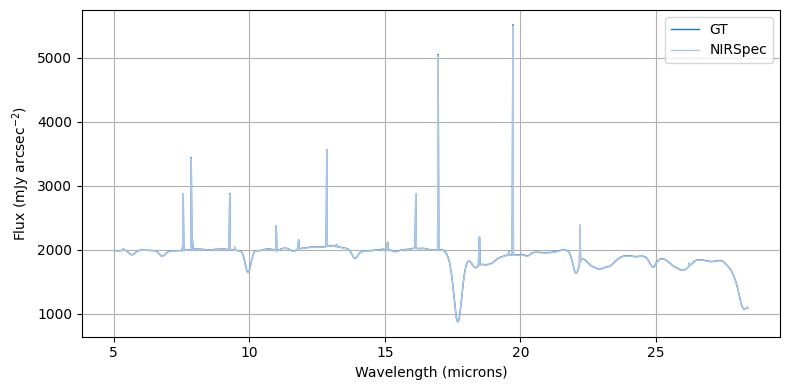

In [234]:
# flat_response = flat.mean(axis=(1, 2)) 
# hs_final_inverted = (hs_final/flat_response[:, np.newaxis, np.newaxis])


plot_spec([GT.mean(axis=(1,2)), hs_final.mean(axis=(1,2))], filters=["GT", "NIRSpec"])

In [16]:
from scipy.optimize import nnls

def unmix_constrained(im, num_endmembers=5, max_iter_NMF=1e20,
          scaler=None, alpha_W=1e-1, alpha_H='same', l1_ratio=0.0):
    # im: (bands, h, w)
    bands, h, w = im.shape
    pixels = im.transpose(1,2,0).reshape(-1, bands)  # (n_pixels, bands)

    # optional rescaling
    if scaler == 1:
        scaler = MinMaxScaler()
        pixels = scaler.fit_transform(pixels)
    elif scaler == 0:
        scaler = (im.min(), im.max())
        pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())

    # 1) run unconstrained NMF to get a warm start for W
    nmf = NMF(n_components=num_endmembers,
              init='nndsvd',
              random_state=42,
              max_iter=int(max_iter_NMF),
              alpha_W=alpha_W,
              alpha_H=alpha_H,
              l1_ratio=l1_ratio)
    W = nmf.fit_transform(pixels)  # (n_pixels, n_endmembers)

    # 2) enforce non-negativity & sum-to-one on W
    W = np.clip(W, 0, None)
    row_sums = W.sum(axis=1, keepdims=True) + 1e-12
    W_norm = W / row_sums        # now rows sum to 1

    # 3) non-negative least squares for each band
    H_nnls = np.zeros((num_endmembers, bands))
    for j in range(bands):
        # solve min_h ≥ 0 || W_norm h − pixels[:,j] ||₂
        h_j, _ = nnls(W_norm, pixels[:, j])
        H_nnls[:, j] = h_j

    # reshape abundances back to (n_endmembers, h, w)
    A = W_norm.reshape(h, w, num_endmembers).transpose(2,0,1)
    E = H_nnls  # (n_endmembers, bands)

    return A, E, scaler

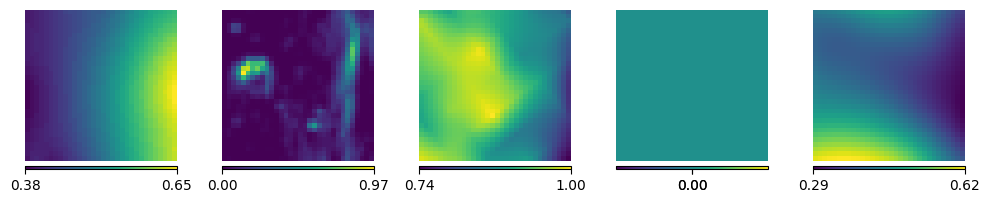

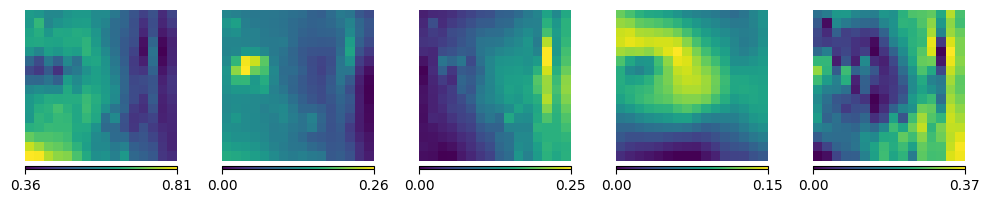

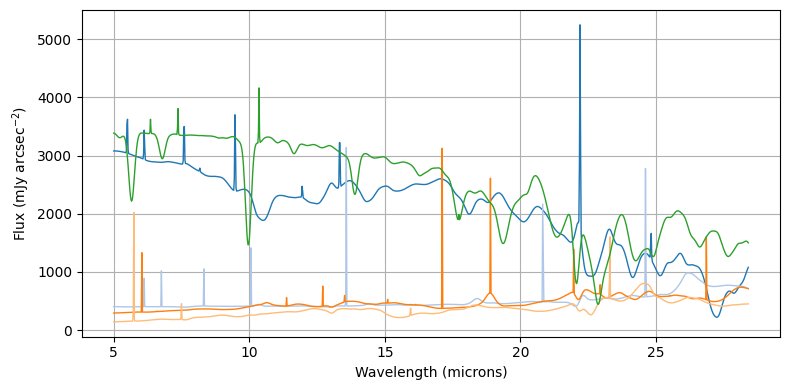

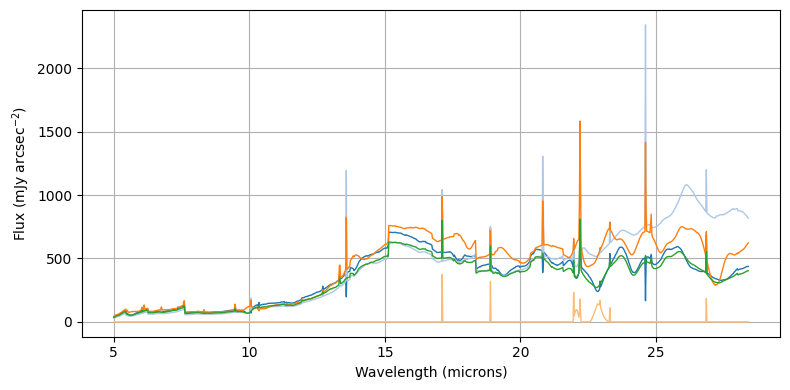

In [17]:
# hs_noisy_inverted = (hs_noisy/L_pce_NIRSpec[:, np.newaxis, np.newaxis])/(L_pce_NIRSpec.max()*100)
A_hs, E_hs, scaler = unmix_constrained(hs_final, scaler=None, alpha_W=1e-8, alpha_H='same', l1_ratio=0.0)

plot_sampled_images(maps[:, margin//2:-margin//2, margin//2:-margin//2], nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_sampled_images(A_hs, nb_columns=5, cbar=True, cbar_position='bottom', size=(10,5))
plot_spec(L_specs)
plot_spec(E_hs)

# E_hs = norm_hypercube(E_hs, min_value=L_specs.min(), max_value=L_specs.max())

np.save(f"/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/lmm_specs_SNR{snr_HS}.npy", E_hs)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/GT_specs.npy", L_specs)
np.save(f"/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/true_maps.npy", maps)
np.save("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/scaler.npy", scaler)